# CoRaLS Monte Carlo acceptance model 

This will step through the main Monte Carlo model and plot some results.

In [1]:
# Note: If using a multithreded kernel, may need to activate package in notebook:
# using Pkg
# pkg"activate ~/projects/CoRaLS.jl/"

# Import and compile modules - slow the first time you run on a fresh kernel
using CoRaLS
using PyPlot
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

Basic run of the Acceptance calculation, specify kw arguments as parameters. Plot results with `plot_acceptance()`.

┌ Info: Calculating acceptance using 1000000 trials across 20 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:51
Simulating... 100%|██████████████████████████████████████| Time: 0:00:26


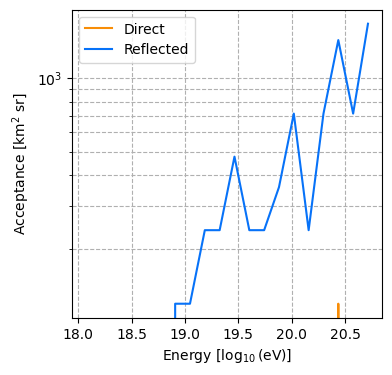

In [2]:
A = acceptance(1000000, 20, region=AllPSR(), spacecraft=CircularOrbit(50km); 
               ice_depth=6.0m,
               min_energy=1.0EeV,
               ν_max=1000MHz,
               dν=30MHz,
               trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m))

plot_acceptance(A)
gcf()  # Show figure in notebook

Specify regions from the following choices:

- `AllPSR()`, `NorthPolePSR()`, `SouthPolePSR()`
- `PolarRegion(pole, angle)`  # pole=:north or :south, angle is degrees from pole
- `CircularRegion(center_lat, center_lon, radius)`  # A circle on the Moon (ex. a crater)
- `WholeMoonRegion()`  # Entire Moon
- `CustomRegion(criteria::Function, area::Float64)`
    - criteria must be a function f(lat, lon) returning a bool (true if in region)
    - area is the area of the region

Specify spacecraft from the following choices:

- `CircularOrbit(altitude)`  # circular orbit, altitude must be in [km]
- `FixedPlatform(lat, lon, altitude)`  # fixed point above lat, lon at altitude in [km]
- `SampledOrbit(latlonalt)`  # matrix of orbital positions to sample 
    - To specify from CSV use `parse_orbit(filename)` # assumes ordered columns time, lon, lat, alt


┌ Info: Calculating acceptance using 100000 trials across 20 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:51
Simulating... 100%|██████████████████████████████████████| Time: 0:00:08


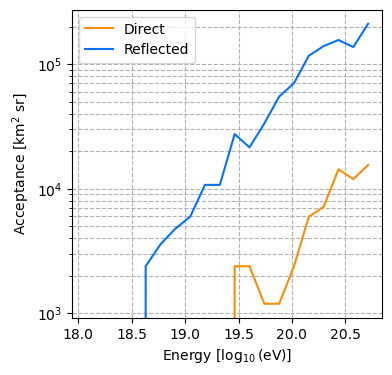

In [3]:
# Define region from 60S to 60N
eq_region = CustomRegion(
    (lat,lon) -> (abs(lat) < 60),  # criteria
    region_area(WholeMoonRegion()) - 2*region_area(PolarRegion(:south, 40))  # area: moon area - 2 polar caps (40deg)
)
lro_orbit = parse_orbit()  # default is LRO orbit: lro_orbit_1yr_2010.csv
ntrials = 100000
A = acceptance(ntrials, 20, region=eq_region, spacecraft=lro_orbit; 
               ice_depth=6.0m,
               min_energy=1.0EeV,
               ν_max=1000MHz,
               dν=30MHz,
               trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m))

plot_acceptance(A)
gcf()  # Show figure in notebook

Info from the resulting `Acceptance` struct

- input params: `ntrials`, `region`, `spacecraft`, `energies` [EeV]
- Accptances (direct, reflected): `dAΩ`, `rAΩ`  [km^2 sr]
- Raw acceptance counts: `dcount`, `rcount`
- Failure counts: `dfailed`, `rfailed`, `failtypes`

The `plot_acceptance` function is just showing dAΩ, rAΩ vs energy with some formatting. Accessing those directly we can make a simple plot:

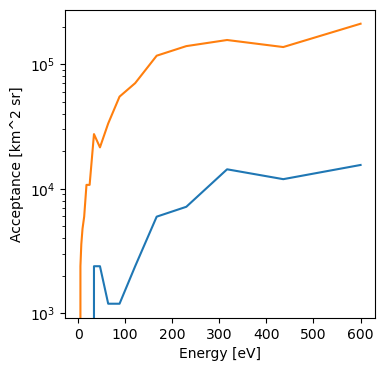

In [4]:
# Note: to plot with pyplot, syntax is same as python but units need to be removed
#  use ustrip(value) or ustrip.(vector) before plotting quantities with units
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot(ustrip.(A.energies[2:end]), ustrip.(A.dAΩ))
plot(ustrip.(A.energies[2:end]), ustrip.(A.rAΩ))
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Acceptance [km^2 sr]")
ax.set_yscale("log")
gcf()

Plot the rejection and acceptance counts colored by energy

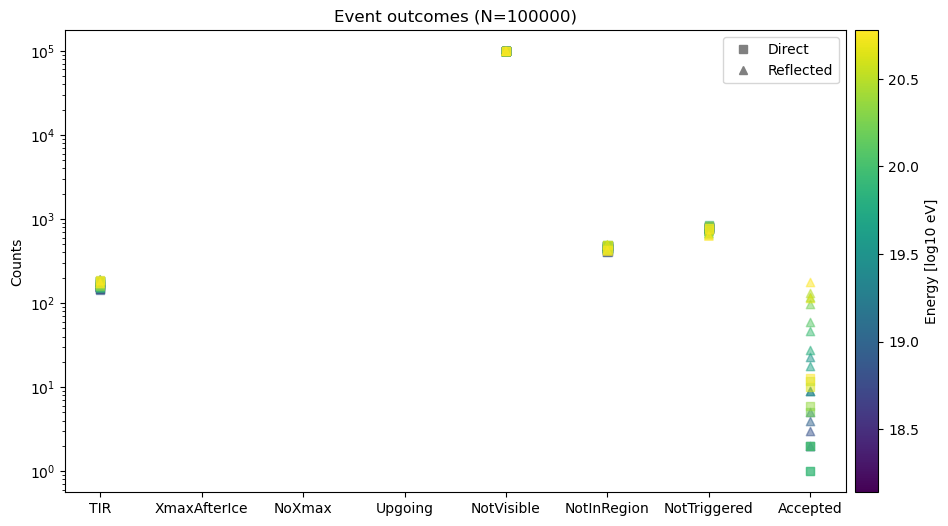

In [5]:
energies = 18.0 .+ log10.(ustrip.(A.energies[2:end]))
failtypes = String.(Symbol.(A.failtypes)) 
norm = matplotlib[:colors][:Normalize](vmin=minimum(energies), vmax=maximum(energies))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for (i, E) in enumerate(energies)
    Es = E*ones(length(failtypes))
    scatter(failtypes, A.dfailed[i,:], marker="s", c=Es, cmap="viridis", norm=norm, alpha=0.5)
    scatter(failtypes, A.rfailed[i,:], marker="^", c=Es, cmap="viridis", norm=norm, alpha=0.5)
    scatter(["Accepted"], A.dcount[i,:], marker="s", c=[E], cmap="viridis", norm=norm, alpha=0.5)
    scatter(["Accepted"], A.rcount[i,:], marker="^", c=[E], cmap="viridis", norm=norm, alpha=0.5)
end

# Set up plot
ax.set_title("Event outcomes (N=$ntrials)")
ax.set_yscale("log")
ax.set_ylabel("Counts")

# Add legend
ax.plot([], [], "s", color="gray", label="Direct")
ax.plot([], [], "^", color="gray", label="Reflected")
ax.legend()

# Add colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label("Energy [log10 eV]")
gcf()

# Running the old version of the model (Remy 2023 model)

- Only configured for the poles (PSR area and geometric factors hardcoded)
- Can't input custom orbit (circular orbit only at pole)
- All TIR events rejected

In [6]:
using CoRaLS
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

Aold = old_acceptance(10000, 20; 
            altitude=40km, 
            ice_depth=6.0m,
            min_energy=1.0EeV,
            ν_max=1000MHz,
            dν=30MHz,
            trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m),
            save_events=false)

┌ Info: Calculating acceptance using 10000 trials across 20 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:118
Simulating... 100%|██████████████████████████████████████| Time: 0:00:20


CoRaLS.OldAcceptance(10000, 40 km, Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr], Unitful.Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(EeV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[1.0 EeV, 1.376916367710489 EeV, 1.8958986836690466 EeV, 2.6104939290646807 EeV, 3.5944318187380233 EeV, 4.949232003839765 EeV, 6.814678553683553 EeV, 9.383242441252527 EeV, 12.919940099556333 EeV, 17.789676992918192 EeV  …  33.72742519377113 

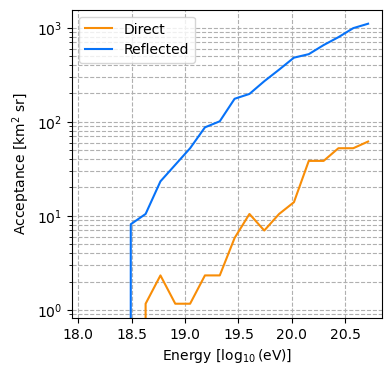

In [7]:
plot_acceptance(Aold)
gcf()

## Comparing New and Old MCMC to analytical (geometric) acceptance


In [8]:
using CoRaLS
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip
using Statistics
using PyPlot
import Logging
Logging.disable_logging(Logging.Info)

# Altitudes and analytical redults (reversed only to frontload longer computations)
altitudes = reverse([1, 40, 50, 60, 100, 500, 1000, 1e5, 1e6]km)
alex = reverse(pi*[10910.1, 426829., 530552., 633120., 1.03223*10^6, 4.23844*10^6, 6.92853*10^6, 1.86423*10^7, 1.89333*10^7])

# Params
ntrials = 10000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20
ice_depth = 20.0m
trigger = trigger_all()
kws = Dict(:ice_depth=>ice_depth,:trigger=>trigger,:min_energy=>1.0EeV, :max_energy=>600.0EeV,:ν_max=>1000MHz,:dν=>30MHz)

results_moon = []
results_psr = []
results_old = []
for altitude in altitudes
    # Note: we create spacecraft explicitly here to pass altitude rather thank using create_spacecraft("orbit:X")
    sc = CircularOrbit(altitude)  

    # New (whole moon)
    A = acceptance(ntrials, nbins, region=WholeMoonRegion(), spacecraft=sc; kws...)
    push!(results_moon, (altitude, mean(A.dAΩ), std(A.dAΩ)))

    # New (PSR only - do more samples)
    AP = acceptance(ntrials*10, nbins, region=AllPSR(), spacecraft=sc; kws...)
    push!(results_psr, (altitude, mean(AP.dAΩ), std(AP.dAΩ)))

    # Old (remy - ntrials are run for each bin instead of total so divide by nbins for consistency)
    AO = old_acceptance(ntrials÷nbins, nbins; altitude=altitude, save_events=false, kws...)
    push!(results_old, (altitude, mean(AO.rAΩ), std(AO.rAΩ)))
end

Simulating... 100%|██████████████████████████████████████| Time: 0:00:10
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
Simulating... 100%|██████████████████████████████████████| Time: 0:00:10
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
Simulating... 100%|██████████████████████████████████████| Time: 0:00:03
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01
Simulating... 100%|████████████████████████████████

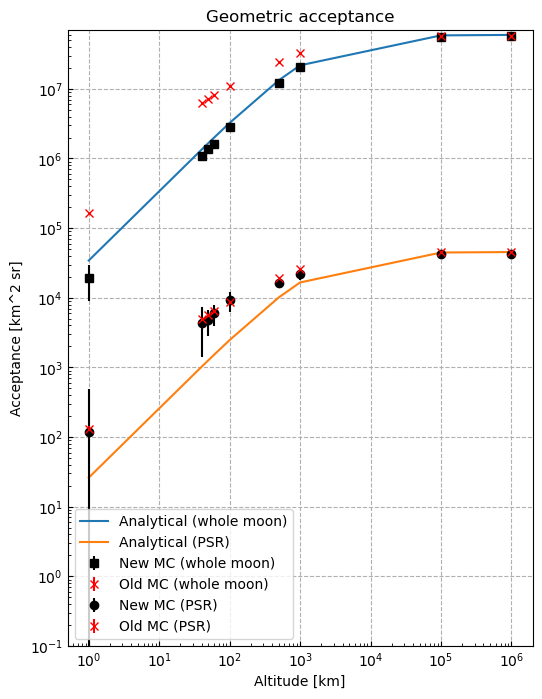

In [9]:
alts = ustrip.(altitudes)
accmoon = ustrip.([r[2] for r in results_moon])
errmoon = ustrip.([r[3] for r in results_moon])
accpsr = ustrip.([r[2] for r in results_psr])
errpsr = ustrip.([r[3] for r in results_psr])
oldacc = ustrip.([r[2] for r in results_old])
olderr = ustrip.([r[3] for r in results_old])

# Plot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["axes.axisbelow"] = true
rcParams["axes.grid"] = true
rcParams["grid.linestyle"] = "dashed"
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"

fig, axs = plt.subplots(1, 1, figsize=(6, 8))
axs.set_title("Geometric acceptance")
axs.loglog(alts, alex, label="Analytical (whole moon)")
axs.errorbar(alts, accmoon, errmoon, fmt="ks", label="New MC (whole moon)")
axs.errorbar(alts, oldacc*(4 * π * 1737.4^2 / 30000), olderr, fmt="rx", label="Old MC (whole moon)")
axs.loglog(alts, alex.*(2.8921e4 / (4 * π * 1737.4^2)), label="Analytical (PSR)")
axs.errorbar(alts, accpsr, errpsr, fmt="ko", label="New MC (PSR)")
axs.errorbar(alts, oldacc, olderr, fmt="rx", label="Old MC (PSR)")
axs.set_ylabel("Acceptance [km^2 sr]")
axs.legend()
axs.set_xlabel("Altitude [km]")
axs.set_ylim(1e-1, 7e7)
gcf()  # Show plot in notebook

In [25]:
ntrials = 10000  # Baseline test: 100_000
ice_depth = 20.0m
trigger = trigger_all()
kws = Dict(:ice_depth=>ice_depth,:trigger=>trigger,:min_energy=>10.0EeV, :max_energy=>1000.0EeV,:ν_max=>1000MHz,:dν=>30MHz)
sc = CircularOrbit(1e6km)
# A = old_acceptance(1000, 10; altitude=1e4km, save_events=false)
A = acceptance(10000, 1, region=WholeMoonRegion(), spacecraft=sc; kws...)

differential_spectrum(A.energies, A.dAΩ, 1yr)


┌ Info: Calculating acceptance using 10000 trials across 1 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:55


1-element Vector{Float64}:
 3.411945838598087e7

In [ ]:
1.4636557829373713e9
5.600806047639868e7
3.0814649938668115e6

In [19]:
log10.(A.energies/1EeV)

3-element Vector{Float64}:
 0.0
 0.5
 1.0